In [35]:
import os

import torch

import numpy as np
import matplotlib.pyplot as plt

from descwl_shear_sims.galaxies import FixedGalaxyCatalog
from descwl_shear_sims.galaxies import WLDeblendGalaxyCatalog
from descwl_shear_sims.stars import StarCatalog, make_star_catalog, DEFAULT_STAR_CONFIG

from descwl_shear_sims.sim import make_sim

from descwl_shear_sims.psfs import make_fixed_psf
from descwl_shear_sims.psfs import make_ps_psf

from descwl_shear_sims.sim import get_se_dim
from tqdm import tqdm
from descwl_shear_sims.layout.layout import Layout 


In [36]:
def Generate_single_img_catalog(
    ntrial, rng, mag, hlr, psf, morph, pixel_scale, layout, coadd_dim, buff, sep, g1, g2, bands, 
    noise_factor, dither, dither_size, rotate, cosmic_rays, bad_columns, star_bleeds, star_catalog, shifts
    ):
    """
    Generate one gatalog and image

    Input:
    ntrial: 
        number of simulation trial
    rng: np.random.RandomState
        The random number generator
    mag: float
        Magnitude of all objects. Objects brighter than magntiude 17 (e.g., 14
        since mags are opposite) tend to cause the Rubin Observatory science
        pipeline detection algorithm to misdetect isolted objects in unphysical
        ways. This effect causes the shear response to be non-linear and so
        metadetect will fail. For this reason, you should use the default
        magnitude of 17 or fainter for this kind of galaxy.
    hlr: float
        Half light radius of all objects
    psf: GSObject or PowerSpectrumPSF
        The psf object or power spectrum psf
    morph: str
        Galaxy morphology, 'exp', 'dev' or 'bd', 'bdk'.  Default 'exp'
    layout: string | Layout, optional
        The layout of objects, either 'grid' or 'random'
    coadd_dim: int, optional
        dimensions of the coadd
    buff: int, optional
        Buffer region with no objects, on all sides of image.  Ingored
        for layout 'grid'.  Default 0.
    pixel_scale: float, optional
        pixel scale in arcsec
    sep: float | None
        Separation of galaxies in arcsec
    g1: 
        shear distortions 1
    g2: 
        shear distortions 2
    bands: list, optional
        Default ['i']
    noise_factor: float, optional
        Factor by which to multiply the noise, default 1
    dither: bool, optional
        Whether to dither the images at the pixel level, default False
    dither_size: float, optional
        The amplitude of dithering in unit of a fraction of a pixel
        for testing pixel interpolation.
        All SE WCS will be given random dithers with this amplitude in both image
        x and y direction.
        Value must be between 0 and 1.  default 0.5.
    rotate: bool, optional
        Whether to randomly rotate the image exposures randomly [not the
        rotation of intrinsic galaxies], default False
    cosmic_rays: bool, optional
        If set to True, add cosmic rays.  Default False.
    bad_columns: bool, optional
        If set to True, add bad columns.  Default False.
    star_bleeds: bool, optional
        If set to True, draw simulated bleed trails for saturated stars.
        Default False
    
    Output: 
    image_tensor:
        simulated image tensor with size (num_of_bands, coadd_dim+10, coadd_dim-10)
    positions_tensor:
        positions of sources, (M, 2)
    M:
        number of sources
    """
    for trial in range(ntrial):
        #print('trial: %d/%d' % (trial+1, ntrial))

        # galaxy catalog; you can make your own
        galaxy_catalog = FixedGalaxyCatalog(
            rng=rng,
            coadd_dim=coadd_dim,
            buff=buff,
            layout=layout,
            mag=mag,
            hlr=hlr,
            morph=morph,
            pixel_scale=pixel_scale
        )

        galaxy_catalog.shifts_array = shifts

        # make a constant gaussian psf
        psf = psf
        if star_catalog is None:
            sim_data = make_sim(
                rng=rng,
                galaxy_catalog=galaxy_catalog,
                coadd_dim=coadd_dim,
                g1=g1,
                g2=g2,
                bands = bands,
                psf=psf,
                noise_factor=noise_factor,
                dither=dither,
                dither_size=dither_size,
                rotate=rotate,
                cosmic_rays=cosmic_rays,
                bad_columns=bad_columns,
                star_bleeds=star_bleeds
            )
        else:
            sim_data = make_sim(
                rng=rng,
                galaxy_catalog=galaxy_catalog,
                star_catalog=star_catalog,
                coadd_dim=coadd_dim,
                g1=g1,
                g2=g2,
                bands = bands,
                psf=psf,
                noise_factor=noise_factor,
                dither=dither,
                dither_size=dither_size,
                rotate=rotate,
                cosmic_rays=cosmic_rays,
                bad_columns=bad_columns,
                star_bleeds=star_bleeds
            )

        truth = sim_data['truth_info']
        image_x_positions = truth['image_x']
        image_y_positions = truth['image_y']
        positions_np = np.stack([image_x_positions, image_y_positions], axis=1)
        M = len(image_x_positions)
        positions_tensor = torch.from_numpy(positions_np).float()

        images = []
        for band in bands:
            image_np = sim_data['band_data'][band][0].image.array
            images.append(torch.tensor(image_np, dtype=torch.float32))
            image_tensor = torch.stack(images, dim=0)  
        
        return image_tensor, positions_tensor, M

In [37]:
def pad_to_max(positions_list):
    """Pad variable-length positions tensors to the same shape."""
    max_sources = max(p.shape[0] for p in positions_list)
    padded_positions = []
    for p in positions_list:
        pad_size = max_sources - p.shape[0]
        if pad_size > 0:
            pad = torch.full((pad_size, p.shape[1]), float('nan'))  # or -999, 0
            p = torch.cat([p, pad], dim=0)
        padded_positions.append(p)
    return torch.stack(padded_positions)

In [38]:
def Generate_img_catalog(
    num_data, ntrial, seed, mag, hlr, psf_type, morph, pixel_scale, layout_name, coadd_dim, buff, sep, 
    bands, noise_factor, dither, dither_size, rotate, cosmic_rays, bad_columns, star_bleeds, star_catalog, shear_setting, density
    ):
    """
    Generate a number of catalogs and images

    Input:
    num_data: 
        number of images
    ntrial: 
        number of simulation trial
    seed: np.random.RandomState
        The random number generator
    mag: float
        Magnitude of all objects. Objects brighter than magntiude 17 (e.g., 14
        since mags are opposite) tend to cause the Rubin Observatory science
        pipeline detection algorithm to misdetect isolted objects in unphysical
        ways. This effect causes the shear response to be non-linear and so
        metadetect will fail. For this reason, you should use the default
        magnitude of 17 or fainter for this kind of galaxy.
    hlr: float
        Half light radius of all objects
    psf_type: str
        PSF type, 'gauss' or 'moffat'
    morph: str
        Galaxy morphology, 'exp', 'dev' or 'bd', 'bdk'.  Default 'exp'
    pixel_scale: float
        pixel scale in arcsec
    layout: string | Layout, optional
        The layout of objects, either 'grid' or 'random'
    coadd_dim: int, optional
        dimensions of the coadd
    buff: int, optional
        Buffer region with no objects, on all sides of image.  Ingored
        for layout 'grid'.  Default 0.
    sep: float | None
        Separation of galaxies in arcsec
    bands: list, optional
        Default ['i']
    noise_factor: float, optional
        Factor by which to multiply the noise, default 1
    dither: bool, optional
        Whether to dither the images at the pixel level, default False
    dither_size: float, optional
        The amplitude of dithering in unit of a fraction of a pixel
        for testing pixel interpolation.
        All SE WCS will be given random dithers with this amplitude in both image
        x and y direction.
        Value must be between 0 and 1.  default 0.5.
    rotate: bool, optional
        Whether to randomly rotate the image exposures randomly [not the
        rotation of intrinsic galaxies], default False
    cosmic_rays: bool, optional
        If set to True, add cosmic rays.  Default False.
    bad_columns: bool, optional
        If set to True, add bad columns.  Default False.
    star_bleeds: bool, optional
        If set to True, draw simulated bleed trails for saturated stars.
        Default False

    Output:
        images: images tensor (num_data, num_of_bands, coadd_dim+10, coadd_dim-10)
        catalogs: dictionary containing generated shear values for g1 and g2
    """
    rng = np.random.RandomState(seed)
    input_dim = get_se_dim(coadd_dim=coadd_dim, rotate=rotate)
    print(f"The input image dimension is {input_dim}")
    
    if star_catalog is None:
        print("Only generating Galaxies")
    
    # constant shear    
    if shear_setting == "const":
        const = 0.05
        g1 = np.ones(num_data) * const
        g2 = np.ones(num_data) * const

    if shear_setting == "vary":
        # Draw from Gaussian
        g1 = np.random.normal(loc=0.0, scale=0.015, size=num_data)
        g2 = np.random.normal(loc=0.0, scale=0.015, size=num_data)

        # Clip values to [-0.05, 0.05]
        g1 = np.clip(g1, -0.05, 0.05)
        g2 = np.clip(g2, -0.05, 0.05)
    
    if psf_type == "gauss":
        psf = make_fixed_psf(psf_type=psf_type) 
    elif psf_type == "moffat":  
        psf = make_fixed_psf(psf_type=psf_type, psf_fwhm=0.8) 

    layout = Layout(
    layout_name=layout_name,
    coadd_dim=coadd_dim,
    pixel_scale=pixel_scale,
    buff=buff)

    shifts = layout.get_shifts(rng, density=density)

    images_list = []
    positions = []
    n_sources = []
    for iter in tqdm(range(num_data)):
        each_image, positions_tensor, M = Generate_single_img_catalog(
            ntrial, rng, mag, hlr, psf, morph, pixel_scale, layout, coadd_dim, buff, sep, g1[iter], g2[iter], 
            bands, noise_factor, dither, dither_size, rotate, cosmic_rays, bad_columns, star_bleeds, star_catalog, shifts
            )
        #'''
        # clip the image to eliminate any rotation or buffer zones
        H = each_image.shape[1]
        W = each_image.shape[2]
        crop_size = 2048

        start_h = (H - crop_size) // 2
        start_w = (W - crop_size) // 2

        end_h = start_h + crop_size
        end_w = start_w + crop_size

        # Crop the center
        single_image = each_image[:, start_h:end_h, start_w:end_w]
        #'''

        if single_image.shape[1] != 2048:
            print("The output dimension is not 2048, check coadd_dim and rotate")
            break
        images_list.append(single_image)
        positions.append(positions_tensor)
        n_sources.append(M)
    
    images = torch.stack(images_list, dim=0)
    plocs = pad_to_max(positions) 
    g1_tensor = torch.from_numpy(g1).float().view(num_data, 1)
    g2_tensor = torch.from_numpy(g2).float().view(num_data, 1)
    n_sources_tensor = torch.tensor(n_sources)
    M = np.max(n_sources)

    return images, plocs, g1_tensor, g2_tensor, n_sources_tensor, M

    

In [39]:
def save_img_catalog(N, images, plocs, n_sources, M, g1, g2, setting=None):
    """
    Save image AND catalog (shear 1, shear 2, convergence (optional), in one dictionary) for TileCatelog generation

    Input:
    N: 
        Number of generated images 
    images:
        tensor contains generated image with shape (num_data, num_of_bands, coadd_dim+10, coadd_dim-10)
    plocs:
        locations of sources in the image, (N, num_of_sources, 2)
    n_sources:
        number of sources in each image, (N, )
    M:
        max number of sources 
    g1: 
        shear distortions 1, (N, 1)
    g2: 
        shear distortions 2, (N, 1)
    Setting:
        A string, name of the setting

    Save following to data/scratch/taoingr/weak_lensing/descwl:
    Dictionary tensor
        {
        "plocs": (N, num_of_sources, 2),
        "n_sources": (N, ),
        "shear_1": (N, M, 1),
        "shear_2": (N, M, 1),
        "convergence" (N, M, 1) # not included yet
            }
    images tenser
    """
    M = plocs.shape[1] 
    shear_1 = g1.view(N, 1, 1).expand(N, M, 1)
    shear_2 = g2.view(N, 1, 1).expand(N, M, 1)

    dict = {
        "plocs": plocs,
        "n_sources": n_sources,
        "shear_1": shear_1,
        "shear_2": shear_2,
        #"convergence": None
    }
    save_folder = f"/data/scratch/taodingr/weak_lensing/descwl/{setting}"
    if not os.path.isdir(save_folder):
        os.makedirs(save_folder)

    torch.save(images, f"/data/scratch/taodingr/weak_lensing/descwl/{setting}/images_{setting}.pt")
    torch.save(dict, f"/data/scratch/taodingr/weak_lensing/descwl/{setting}/catalog_{setting}.pt")

    print(f"Image saved to: /data/scratch/taodingr/weak_lensing/descwl/{setting}/images_{setting}.pt")
    print(f"Catalog saved to: /data/scratch/taodingr/weak_lensing/descwl/{setting}/catalog_{setting}.pt")



In [5]:
# Default setting for the two function 
seed = None

num_data = 200
ntrial = 2
rng = np.random.RandomState(seed)
mag = 17.0
hlr = 0.5
psf = make_fixed_psf(psf_type='gauss')
morph = 'exp'
pixel_scale = 0.2
layout = None # 'random' or 'grid'
coadd_dim = None # int
buff = 0 
sep = None 
bands = ['i']
noise_factor = 1.0 
dither = False
dither_size = 0.5
rotate = False
cosmic_rays = False
bad_columns = False
star_bleeds = False
star_catalog = None


In [5]:
# Default setting for the two function 
seed = None

num_data = 200
ntrial = 2
rng = np.random.RandomState(seed)
mag = 17.0
hlr = 0.5
psf = make_fixed_psf(psf_type='gauss')
morph = 'exp'
layout = None # 'random' or 'grid'
coadd_dim = None # int
buff = 0 
sep = None 
bands = ['i']
noise_factor = 1.0 


### Simulation setting in `Metadetection Weak Lensing for the Vera C. Rubin Observatory` by Sheldon et al.

- 10 yr LSST noise level `i.e. noise_factor=0.58`

- **Pixel scale** 0.2 arcseconds `i.e. pixel_scale=0.2`

- Each image has a **random rotation** applied `i.e. rotate=True`

- **Dither** with unrealistically small size `i.e. dither=True, dither_size=0.01`

- Avoid edge effect `i.e. buff=50`

- For basic **PSF model**: Moffat PSF with shape parameter $\beta = 2.5$, FWHM of 0.8 arcseconds

- For spatially variable PSF model: varying both the ellipticity and size across the image

- Generated **bad columns** and **cosmic rays** `i.e. bad_columns=True, cosmic_rays=True`

- Generated **stars** using fluxes and Milky Way densities sampled from DC2, rejecting densities higher than 100 per square arcminute (by default), `i.e. StarCatalog`

- Drawn **bleed** to saturated stars `i.e. star_bleeds=True`

- Tested both random and grid layout, random layout for realistic galaxy population `i.e. layout='random'`, grid is applied to boost shear recovery test

    - **Base Simulation**:  `grid` layout; `i` band; elliptical color galaxys with bulge, disk and AGN components; same morphology for components in each band; effective iband ab magnitude limit 27 

    - **Real Simulation**:  `random` layout; `r, i, z` bands; single component, round exponential galaxys with fixed flux and size.

- Add a constant to image background (not sure how to do it)

- Two types of **shear** pattern
    - shear with constant magnitude (0.02) and same orientation
    - shear with constant magnitude (0.02) but random orientation for each image
    

- Galaxies Density:  240 galaxies per square arcminute

#### Adopt the Realistic Simulation setting below:



In [40]:
import os
os.environ['CATSIM_DIR'] = '/data/scratch/taodingr/lsst_stack/catsim' 

In [42]:
num_data = 10
ntrial = 2
seed = 8312
mag = 17
hlr = 0.5
psf = "moffat"
morph = 'exp'
pixel_scale = 0.2
layout_name = 'random'
# coadd_dim = 2038
coadd_dim = 2550
buff = 0
sep = 9.5
bands = ['i']
noise_factor=0.58
dither = True
dither_size = 0.5
rotate = False
cosmic_rays = True 
bad_columns = True 
star_bleeds = False 
shear_setting = "vary"

density = 80 # per square arcmin, 80 is default  

# star_config = DEFAULT_STAR_CONFIG
star_config = {'density': 10}

#'''
star_catalog = make_star_catalog(
    rng=rng,
    coadd_dim=coadd_dim,
    buff=buff,
    pixel_scale=pixel_scale,
    star_config = star_config
    )
#'''
star_catalog = None

images_meta, plocs_meta, g1_meta, g2_meta, n_sources_meta, M_meta = Generate_img_catalog(
    num_data, ntrial, seed, mag, hlr, psf, morph, pixel_scale, layout_name, coadd_dim, buff, sep, 
    bands, noise_factor, dither, dither_size, rotate, cosmic_rays, bad_columns, star_bleeds, star_catalog, shear_setting, density
    )

no coadd_scale or se_scale. Assume they are the same
The input image dimension is 2560
Only generating Galaxies


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:52<00:00,  5.28s/it]


In [43]:
# check shape of images_meta
images_meta.shape

torch.Size([10, 1, 2048, 2048])

In [ ]:
# check number of NaNs
num_nans = torch.isnan(images_meta).sum().item()
print(f"Number of NaNs: {num_nans}")

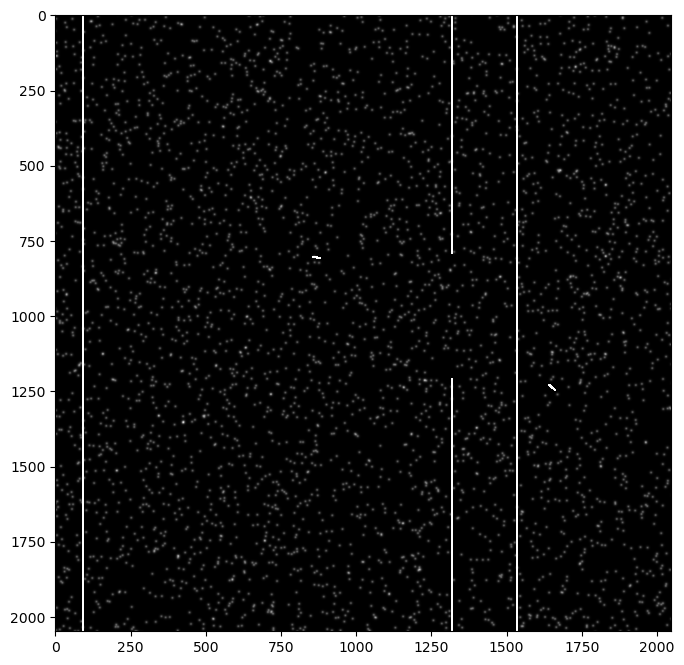

In [44]:
plt.figure(figsize=(8, 8), dpi=100)  # Larger figure with higher DPI
plt.imshow(images_meta[0][0], cmap='gray', origin='upper')
plt.show()

In [ ]:
save_img_catalog(num_data, images_meta, plocs_meta, n_sources_meta, M_meta, g1_meta, g2_meta, "meta_2560_cosmic_badcol")

### Simulation Settings in  `A differentiable perturbation-based weak lensing shear estimator`  by Li et al.

- Image pixel scale is set to 0.2 (default)

- round Moffat PSF with FWHM=0.8 (the author also used HSC-like PSF with ellipticity $e_1 = 0.02, e_2 = -0.02$ to test the additive bias)

- noise level matched the LSST 10 years setting (I assume default here)

- use `'griz'` bands, same galaxy profiles and PSF across bands

- noise variance are different across bands

- no dithering (default)

- coadd image with inverse variance weight of background noise

The author also used following method to contrain shear bias, not sure whether the `descwl_shear_sims` package can accommodate

- generate image pair for each galaxy with different shear ($g_1 = 0.02, g_2 = 0$) and ($g_1 = 0, g_2 = 0.02$)

- For each pair, the image have same morphology and brightness, but orthogonal to each other.

- galaxy density is about 230 spare $\text{arcmin}^{-1}$


In [7]:
seed = 42

num_data = 200
ntrial = 2
rng = np.random.RandomState(seed)
mag = 17 # default
hlr = 0.5 # default
psf = make_fixed_psf(psf_type='moffat', psf_fwhm=0.8)
morph = 'exp' # default
layout = 'random' # use example setting
coadd_dim = 2038
buff = 1
sep = None
bands = ['g', 'r', 'i', 'z']
noise_factor=1

images_adp, catalogs_adp = Generate_img_catalog(num_data, ntrial, rng, mag, hlr, psf, morph, layout, coadd_dim, buff, sep, bands, noise_factor)

100%|██████████| 200/200 [37:14<00:00, 11.17s/it]


In [8]:
images_adp.shape

torch.Size([200, 4, 2048, 2048])

### Simulation Settings in `Analytical Noise Bias Correction for Precise Weak Lensing Shear Inference` by Li et al.

- Constant shear $\gamma_1 = \pm 0.02$ (two shear or one shear?)

- The simulation is divided into 10000 subfields for each test case, and each subfield is 0.06 square degrees.

- creating a 90 degree rotated companion for each subfields

- round Moffat PSF with FWHM=0.8

- Applyed Gaussian noise after the background subtraction, to simulate the residual Poisson noise. done with package `WeakLensingDeblending`?

- standardized the images to a consistent zero point of 30

- use 'griz' bands

- anticipated ten-year LSST noise levels (I assume default here)

In [ ]:
seed = 42

num_data = 200
ntrial = 2
rng = np.random.RandomState(seed)
mag = 17 # default
hlr = 0.5 # default
psf = make_fixed_psf(psf_type='moffat', psf_fwhm=0.8)
morph = 'exp' # default
layout = 'random' # use example setting
coadd_dim = 2038
buff = 1
sep = None
bands = ['g', 'r', 'i', 'z']
noise_factor=1

images_adp, catalogs_adp = Generate_img_catalog(num_data, ntrial, rng, mag, hlr, psf, morph, layout, coadd_dim, buff, sep, bands, noise_factor)